In [4]:
from transformers import pipeline

In [5]:
od_pipe = pipeline("object-detection", model = "facebook/detr-resnet-50")

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [7]:
from PIL import Image
import requests

In [8]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# raw_image = Image.open('huggingface_friends.jpg')
# raw_image.resize((569, 491))

In [9]:
pipeline_output = od_pipe(image)

In [16]:
# Helper Functions
import matplotlib.pyplot as plt
import io


def load_image_from_url(url):
    return Image.open(requests.get(url, stream=True).raw)

def render_results_in_image(in_pil_img, in_results):
    plt.figure(figsize=(16, 10))
    plt.imshow(in_pil_img)

    ax = plt.gca()

    for prediction in in_results:

        x, y = prediction['box']['xmin'], prediction['box']['ymin']
        w = prediction['box']['xmax'] - prediction['box']['xmin']
        h = prediction['box']['ymax'] - prediction['box']['ymin']

        ax.add_patch(plt.Rectangle((x, y),
                                   w,
                                   h,
                                   fill=False,
                                   color="green",
                                   linewidth=2))
        ax.text(
           x,
           y,
           f"{prediction['label']}: {round(prediction['score']*100, 1)}%",
           color='red'
        )

    plt.axis("off")

    # Save the modified image to a BytesIO object
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png',
                bbox_inches='tight',
                pad_inches=0)
    img_buf.seek(0)
    modified_image = Image.open(img_buf)

    # Close the plot to prevent it from being displayed
    plt.close()

    return modified_image

In [17]:
processed_image = render_results_in_image(
    image, 
    pipeline_output)

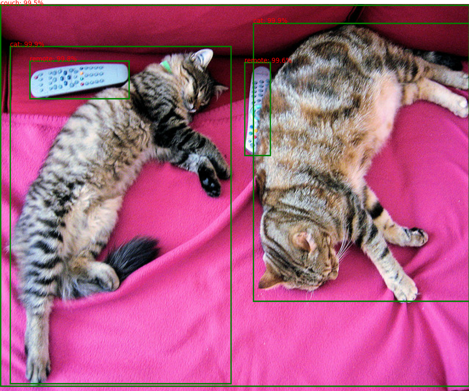

In [20]:
processed_image.resize((469, 391))

In [21]:
import os
import gradio as gr

def get_pipeline_prediction(pil_image):
    pipeline_output = od_pipe(pil_image)
    processed_image = render_results_in_image(pil_image, pipeline_output)
    
    return processed_image

In [22]:
demo = gr.Interface(
  fn=get_pipeline_prediction,
  inputs=gr.Image(label="Input image", 
                  type="pil"),
  outputs=gr.Image(label="Output image with predicted instances",
                   type="pil")
)

In [ ]:
demo.launch(share=True, server_port=52505)

In [24]:
demo.close()

Closing server running on port: 52505


### Make an AI Powered Audio Assistant

- Combine the object detector with a text-to-speech model that will help dictate what is inside the image.

- Inspect the output of the object detection pipeline.

In [25]:
pipeline_output

[{'score': 0.9982202649116516,
  'label': 'remote',
  'box': {'xmin': 40, 'ymin': 70, 'xmax': 175, 'ymax': 117}},
 {'score': 0.9960021376609802,
  'label': 'remote',
  'box': {'xmin': 333, 'ymin': 72, 'xmax': 368, 'ymax': 187}},
 {'score': 0.9954743981361389,
  'label': 'couch',
  'box': {'xmin': 0, 'ymin': 1, 'xmax': 639, 'ymax': 473}},
 {'score': 0.99880051612854,
  'label': 'cat',
  'box': {'xmin': 13, 'ymin': 52, 'xmax': 314, 'ymax': 470}},
 {'score': 0.9986783862113953,
  'label': 'cat',
  'box': {'xmin': 345, 'ymin': 23, 'xmax': 640, 'ymax': 368}}]

In [26]:
od_pipe

In [29]:
import inflect

def summarize_predictions_natural_language(predictions):
    summary = {}
    p = inflect.engine()

    for prediction in predictions:
        label = prediction['label']
        if label in summary:
            summary[label] += 1
        else:
            summary[label] = 1

    result_string = "In this image, there are "
    for i, (label, count) in enumerate(summary.items()):
        count_string = p.number_to_words(count)
        result_string += f"{count_string} {label}"
        if count > 1:
          result_string += "s"

        result_string += " "

        if i == len(summary) - 2:
          result_string += "and "

    # Remove the trailing comma and space
    result_string = result_string.rstrip(', ') + "."

    return result_string


In [30]:
text = summarize_predictions_natural_language(pipeline_output)

In [31]:
text

'In this image, there are two remotes one couch and two cats.'

In [32]:
tts_pipe = pipeline("text-to-speech",
                    model="kakao-enterprise/vits-ljs")

config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/145M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.14k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/47.0 [00:00<?, ?B/s]

In [35]:
narrated_text = tts_pipe(text)

RuntimeError: espeak not installed on your system